In [1]:
import numpy as np
import pandas as pd

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)

In [3]:
df = pd.read_parquet('cleaned/movielens_parquet')

In [4]:
df.isnull().sum()

movieId           0
title             0
genres            0
year            245
review_data    4708
imdbId            0
tmdbId           62
num_reviews       0
dtype: int64

Exporting and importing in parquet leaded to the the conversion of the lists in movielens data in review_data column to numpy arrays. We need to convert them back to lists to use the same approach as Netflix to take samples.

*@Jaume maybe for you this is not the case because you have ios.*

In [5]:
# convert numpy arrays to lists in the 'review_data' column
df['review_data'] = df['review_data'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [6]:
# Step 1: Count the number of dictionaries per row in the review_data column, replacing NaN with 0
df['num_reviews'] = df['review_data'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Step 2: Divide the dataset into strata based on the number of reviews for each movie
quintiles = df['num_reviews'].quantile([0, 0.20, 0.40, 0.60, 0.80, 1.0])

# Adjust the boundaries to ensure monotonic increase
stratum_boundaries = [0, quintiles[0.20], quintiles[0.40], quintiles[0.60], quintiles[0.80], quintiles[1.0]]
stratum_labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

# Create a new column to categorize movies into strata based on the number of reviews
df['review_stratum'] = pd.cut(df['num_reviews'], bins=stratum_boundaries, labels=stratum_labels)

In [7]:
import random

sampled_df = df[df.columns]

# Step 1: Count the number of dictionaries per row in the review_data column
sampled_df['num_reviews'] = df['review_data'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Step 2: Divide the dataset into strata based on the number of reviews for each movie
quintiles = sampled_df['num_reviews'].quantile([0, 0.20, 0.40, 0.60, 0.80, 1.0])
# Adjust the boundaries to include fewer movies with a large number of reviews
stratum_boundaries = [0, quintiles[0.20], quintiles[0.40], quintiles[0.60], quintiles[0.80], quintiles[1.0]]
stratum_labels = ['Q1', 'Q2', 'Q3', 'Q4','Q5']

# Create a new column to categorize movies into strata based on the number of reviews
sampled_df['review_stratum'] = pd.cut(sampled_df['num_reviews'], bins=stratum_boundaries, labels=stratum_labels)

# Step 3: Define sample size per stratum
sample_size_per_stratum = 40

# Step 4: Within each stratum, apply random sampling techniques to select movies
sampled_movies = []

# Iterate over each stratum
for stratum in sampled_df['review_stratum'].dropna().unique():  # Drop NaN values
    # Filter movies in the current stratum
    stratum_movies = sampled_df[sampled_df['review_stratum'] == stratum]
    
    # Apply simple random sampling to select movies within the stratum
    sampled_indices = random.sample(list(stratum_movies.index), sample_size_per_stratum)
    sampled_movies.extend(sampled_indices)

# Step 5: Create the sampled DataFrame
sampled_df_movielens = sampled_df.loc[sampled_movies, ['movieId', 'review_data', 'genres', 'year', 'title', 'review_stratum','num_reviews']]

In [8]:
# Extract all user IDs from the 'review_data' column using list comprehension
user_ids = [review_entry.get('userId') for row in sampled_df_movielens['review_data'] for review_entry in row if review_entry.get('userId')]

# Count the number of unique users and reviews
unique_users = set(user_ids)
amount_of_reviews = len(user_ids)

# Calculate averages
avg_reviews_per_unique_user = amount_of_reviews / len(unique_users)
avg_reviews_per_movie_id = amount_of_reviews / len(sampled_df_movielens)

# Print results
print("There are {} reviews in the sampled dataframe.".format(amount_of_reviews))
print("There are {} unique users who have reviewed a movie.".format(len(unique_users)))
print("There are {} movieIds in the sampled dataset.".format(len(sampled_df_movielens)))
print("A unique user places {} reviews on average in the sampled dataset.".format(round(avg_reviews_per_unique_user)))
print("A movieId receives {} reviews on average in the sampled dataset.".format(round(avg_reviews_per_movie_id)))

There are 16555 reviews in the sampled dataframe.
There are 14324 unique users who have reviewed a movie.
There are 200 movieIds in the sampled dataset.
A unique user places 1 reviews on average in the sampled dataset.
A movieId receives 83 reviews on average in the sampled dataset.


Let's use the same functions as in Netflix EDA to eyeball distributions before statistically checking whether the sample is representative or not:

In [9]:
import datetime
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
from scipy.stats import kruskal

def get_month_name(month_num):
    """
    Convert a numeric month to its corresponding name.

    Parameters:
    month_num (int): Numeric representation of a month (1-12).

    Returns:
    str: Name of the month.
    """
    return datetime.date(1900, month_num, 1).strftime('%B')

def extract_rating_date_plot_freq(df_list):
    """
    Extract ratings data from a list of DataFrames and plot the frequency of ratings per month.

    Parameters:
    df_list (list): List of DataFrames containing ratings data.

    Returns:
    None
    """
    plt.figure(figsize=(12, 8))
    for idx, df in enumerate(df_list):
        var_name = [name for name, value in globals().items() if value is df][0]
        ratings_per_month = {month: 0 for month in range(1, 13)}
        for row in df['review_data'].values:
            if row is not None:  # Skip None values
                for entry in row:
                    month = entry['date'].month
                    ratings_per_month[month] += 1

        months = list(ratings_per_month.keys())
        freq = list(ratings_per_month.values())
    
        plt.bar(months, freq, alpha=0.5, label=var_name)

        # Add text labels on top of each bar
        for month, f in zip(months, freq):
            plt.text(month, f, str(f), ha='center', va='bottom')

    plt.xlabel('Month')
    plt.ylabel('Frequency')
    plt.title('Frequency of Ratings per Month')
    plt.legend()
    plt.xticks(range(1, 13), [get_month_name(month) for month in range(1, 13)], rotation=90)  # Rotate x-axis labels
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [10]:
def extract_count_rating_per_movie_and_plot(df_list, term):
    """
    Extract average rating per movie from a list of DataFrames and plot the distribution.

    Parameters:
    df_list (list): List of DataFrames containing ratings data.
    term (str): Term specifying the type of rating to extract (e.g., 'rating', 'usefulness').

    Returns:
    None
    """
    plt.figure(figsize=(12, 8))
    for df in df_list:
        var_name = next(name for name, value in globals().items() if value is df)
        avg_ratings = []
        for row in df['review_data'].values:
            if row is not None:  # Skip None values
                ratings = [entry[term] for entry in row if entry is not None]  # Skip None entries
                avg_rating = len(ratings)
                avg_ratings.append(avg_rating)  
        plt.hist(avg_ratings, bins=20, alpha=0.5, label=var_name, density=True)  # Adjust the number of bins as needed
    plt.xlabel('Count of {}'.format(term))
    plt.ylabel('Density')
    plt.title('Distribution of counts of {} per movie'.format(term))
    plt.legend()
    plt.show()

In [11]:
def extract_rating_kruskal_wallis(df_list):
    """
    Perform Kruskal-Wallis test on ratings data from a list of DataFrames.

    Parameters:
    df_list (list): List of DataFrames containing ratings data.

    Returns:
    pandas.DataFrame: DataFrame containing Kruskal-Wallis test results including H-statistic, p-value, and whether to reject the null hypothesis.
    """
    results = []
    for df in df_list:
        var_name = next(name for name, value in globals().items() if value is df)
        ratings_per_month = {month: [] for month in range(1, 13)}
        total_ratings = 0
        
        # Extract ratings and months from review_data without None values
        ratings_data = [(entry['rating'], entry['date'].month) 
                        for row in df['review_data'].values if row is not None
                        for entry in row if entry is not None]
        
        # Group ratings by month
        for rating, month in ratings_data:
            ratings_per_month[month].append(rating)
            total_ratings += 1
        
        # Compute Kruskal-Wallis test
        kruskal_data = [ratings_per_month[month] for month in range(1, 13)]
        h_statistic, p_value = kruskal(*kruskal_data)
        
        # Append results
        results.append({'Sample': var_name, 'H-Statistic': h_statistic, 'P-value': p_value,'Amount of MovieIds':len(df),'Amount of Ratings': total_ratings})

    results_df = pd.DataFrame(results)
    results_df['Reject Null Hypotheses'] = results_df['P-value'] < 0.05

    return results_df

In [12]:
def compare_genre_frequencies(df1, df2):
    """
    Compare the frequencies of genres between two dataframes and plot the results.

    Parameters:
    df1 (DataFrame): First DataFrame containing genres data.
    df2 (DataFrame): Second DataFrame containing genres data.

    Returns:
    None
    """
    # Flatten the lists of genres for both dataframes, skipping None values
    all_genres_df1 = [genre for sublist in df1['genres'] if sublist is not None for genre in sublist]
    all_genres_df2 = [genre for sublist in df2['genres'] if sublist is not None for genre in sublist]

    # Count the frequencies of genres in both dataframes
    genre_counts_df1 = {genre: all_genres_df1.count(genre) for genre in set(all_genres_df1)}
    genre_counts_df2 = {genre: all_genres_df2.count(genre) for genre in set(all_genres_df2)}

    # Sort genre counts dictionaries by frequency in descending order
    genre_counts_df1_sorted = dict(sorted(genre_counts_df1.items(), key=lambda item: item[1], reverse=True))
    genre_counts_df2_sorted = dict(sorted(genre_counts_df2.items(), key=lambda item: item[1], reverse=True))

    # Plot the genre frequencies
    plt.figure(figsize=(12, 8))  # Set the figure size
    plt.bar(genre_counts_df1_sorted.keys(), genre_counts_df1_sorted.values(), alpha=0.5, label='Sample DF')
    plt.bar(genre_counts_df2_sorted.keys(), genre_counts_df2_sorted.values(), alpha=0.5, label='DF')

    # Add text labels on top of each bar
    for genre, freq in genre_counts_df1_sorted.items():
        plt.text(genre, freq, str(freq), ha='center', va='bottom', rotation=90)
    for genre, freq in genre_counts_df2_sorted.items():
        plt.text(genre, freq, str(freq), ha='center', va='bottom', rotation=90)

    plt.xlabel('Genre')
    plt.ylabel('Frequency')
    plt.title('Comparison of Genre Frequencies')
    plt.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

,Sample,H-Statistic,P-value,Amount of MovieIds,Amount of Ratings,Reject Null Hypotheses
0,sampled_df_movielens,14.151871,2.247035e-01,200,16555,False
1,df,709.068495,6.135778e-145,50629,3932962,True


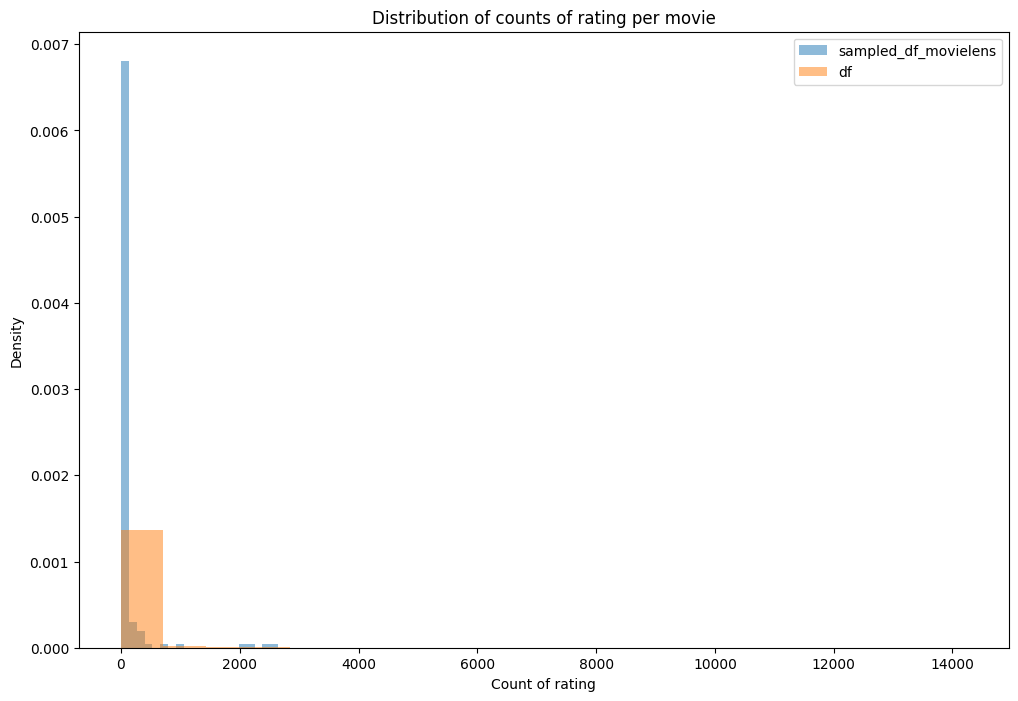

Because sample sizes differ a lot, density has been set to true to see differences more clearly.


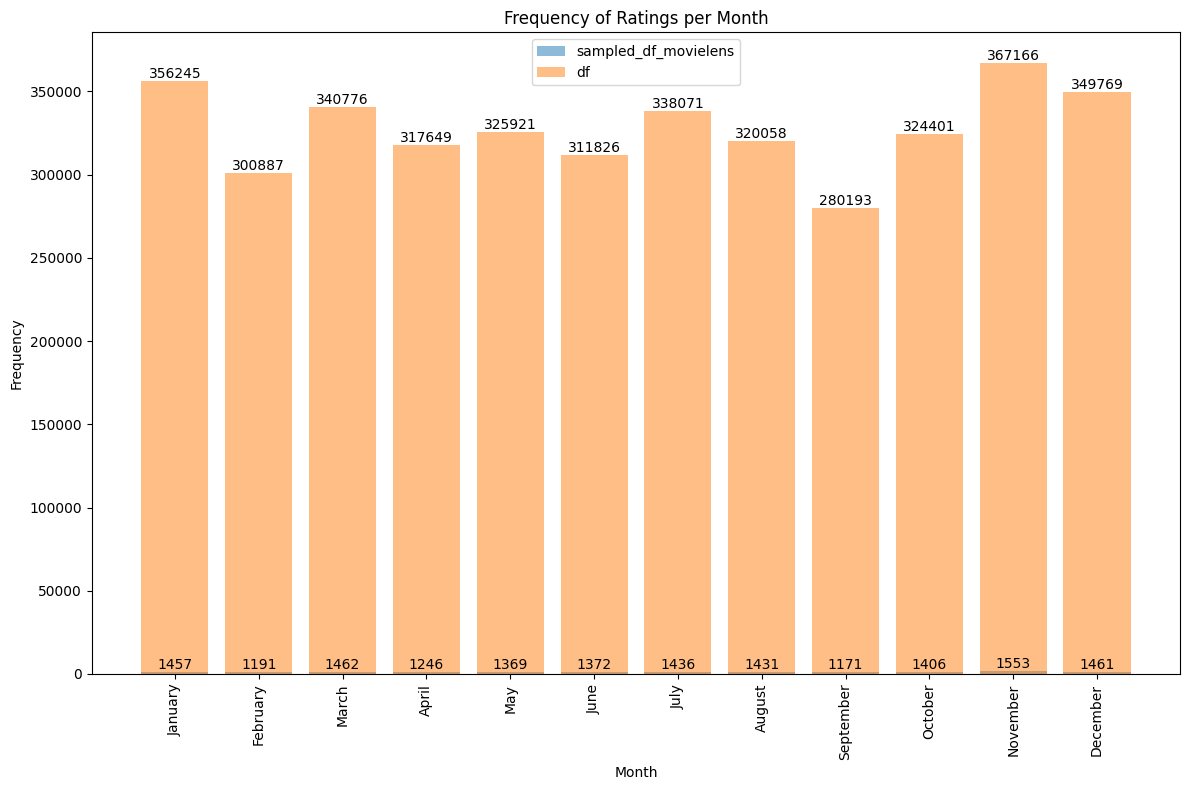

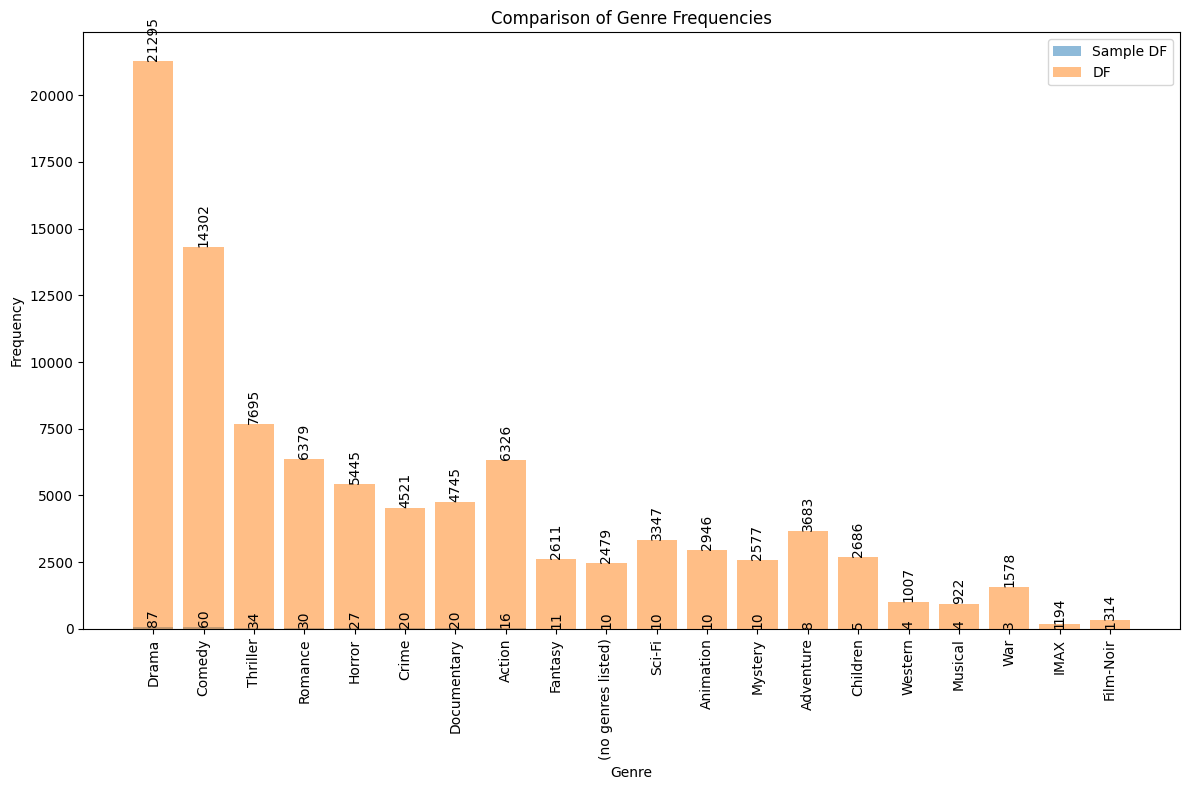

In [13]:
df_list = [sampled_df_movielens,df]
extract_rating_kruskal_wallis(df_list)
extract_count_rating_per_movie_and_plot(df_list,'rating')
print('Because sample sizes differ a lot, density has been set to true to see differences more clearly.')
extract_rating_date_plot_freq(df_list)  
compare_genre_frequencies(sampled_df_movielens, df)

The same goes on here as it did with Netflix, hard to see whether this is good sample by just eyeballing the graphs. Let's statistically check if the taken sample is representative:

*We perform a independent t-test, as ratings are normally distributed.*

In [14]:
from scipy.stats import ttest_ind

# Define the strata
strata = sampled_df_movielens['review_stratum'].unique()

# Perform t-tests for each stratum
t_statistics = {}
p_values = {}
for stratum in strata:
    # Extract the 'num_reviews' column for the current stratum
    sampled_num_reviews_stratum = sampled_df_movielens[sampled_df_movielens['review_stratum'] == stratum]['num_reviews']
    population_num_reviews_stratum = df[df['review_stratum'] == stratum]['num_reviews']
    
    # Perform the t-test
    t_statistic, p_value = ttest_ind(sampled_num_reviews_stratum, population_num_reviews_stratum)
    
    # Store the results
    t_statistics[stratum] = t_statistic
    p_values[stratum] = p_value

# Print the results
print("T-test Results:")
for stratum in strata:
    print(f"Stratum: {stratum}")
    print(f"T-statistic: {t_statistics[stratum]}")
    print(f"P-value: {p_values[stratum]}")
    alpha = 0.05
    if p_values[stratum] < alpha:
        print("The difference in means is statistically significant (reject the null hypothesis)")
    else:
        print("The difference in means is not statistically significant (fail to reject the null hypothesis)")


T-test Results:
Stratum: Q5
T-statistic: 0.13731772763503636
P-value: 0.8907824013932707
The difference in means is not statistically significant (fail to reject the null hypothesis)
Stratum: Q4
T-statistic: 0.2837884804930789
P-value: 0.7765793876213372
The difference in means is not statistically significant (fail to reject the null hypothesis)
Stratum: Q3
T-statistic: 0.08977499227750664
P-value: 0.9284691915133814
The difference in means is not statistically significant (fail to reject the null hypothesis)
Stratum: Q2
T-statistic: nan
P-value: nan
The difference in means is not statistically significant (fail to reject the null hypothesis)
Stratum: Q1
T-statistic: nan
P-value: nan
The difference in means is not statistically significant (fail to reject the null hypothesis)


c:\Users\SJYHa\Desktop\venv_ddb\ddb_pymer4\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Differences in mean betweens sample and df is not significant, meaning the sample is representatitve!

In [15]:
sampled_df_movielens.to_parquet('cleaned/strat_sample_movielens')